# Accurately Modeling Cross-Talk

The purpose of this notebook is to provide an example of how a custom pass could model cross-talk noise between qubits in a circuit.

First, we need to figure out when different qubits are in parallel delays.

In [2]:
from qiskit.transpiler.basepasses import TransformationPass
from qiskit.dagcircuit import DAGCircuit
from qiskit import QuantumRegister
from qiskit.circuit import Delay
from pprint import pprint


DEBUG = True
VERBOSE = True
#Cross talk delay pass, in here temporarily for immediate use
class CrossTalkDelayReplace(TransformationPass):
    """Adds cross-talk delay error information to circuit metadata for noise model post processing"""

    def __init__(self, coupling_map):
        """CrossTalk initializer
        Args:
            coupling_map (list(list(int)) or None): Coupling map for provided backend.  If None, pass will
                  not run
        """
        super().__init__()
        self.coupling_map = coupling_map
    
    def initQubitMapping(self, dag):
        """Initialize the qubit mapping to index and provide convenient
            variables for current time, if the previous op was a delay, and
            what the previous op's duration was.  For use when iterating over
            the DAG.

        Args:
            dag (DAGCircuit): the DAG to be optimized
            
        Returns:
            mapping of qubit to index and other loop variables (described above)
        """
        return {qubit: {"idx": i,
                        "currTime": 0,
                        "prevOpDelay": False,
                        "prevOpDuration": 0,
                       }
                for i, qubit in enumerate(dag.qubits)}
    
    def splitDelay(self, startTime, duration, pivotTimes):
        """Splits a delay based on 'pivotTimes' array.

        Args:
            startTime  (int)      : delay start time
            duration   (int)      : delay duration
            pivotTimes (List(int)): list of times to split on
            
        Returns:
            dag (DAGCircuit): the list of new delays to replace the old one
        """
        endTime = startTime + duration
        
        #split and do stuff based on start and end times
        newCircuit = DAGCircuit()
        reg = QuantumRegister(1)
        newCircuit.add_qreg(reg)
        
        #need to split at every array element of pivotTimes in between startTime and endTime
        lastTime = startTime
        for time in pivotTimes:
            #need to not add delay of length 0 (startTime <)
            # but need to include the last delay until the end time (<= endTime)
            if startTime < time <= endTime:
                #split
                newCircuit.apply_operation_back(Delay(duration=time-lastTime), [reg[0]], [])
                lastTime = time
        
        return newCircuit
    
    def run(self, dag):
        """Run the DelayReplace pass on 'dag'.

        Args:
            dag (DAGCircuit): the DAG to be optimized

        Returns:
            DAGCircuit: the optimized DAG.
        """

        if self.coupling_map is None:
            return dag


        #extract start and end times of all delays in the entire circuit
        qubit_mapping = self.initQubitMapping(dag)
        numQubits = dag.num_qubits() #returns all, including the ancilla used to pad out to full backend capacity
        startTimes = []
        endTimes = []
        
        #if there's a coupling map when transpiled, it flattens all other registers
        #####dag.qubits <- the order of this list is the order in the coupling map
        ## backend has a configuration.num_qubits or something like that
        
        #iterate and extract times
        ##this relies on the assumption that each node returned by serial_layers is
        ## in natural time order per qubit (not overall, only within each qubit)
        for layer in dag.serial_layers():
            op = layer['graph'].op_nodes()[0].op
            qubits = layer['partition'][0]
            duration = op.duration
            if DEBUG and VERBOSE: print(op, qubits, duration)

            
            for qubit in qubits:
                if DEBUG and VERBOSE: print("Operating on qubit ", qubit)
                #check op type
                if isinstance(op, Delay):
                    if DEBUG and VERBOSE: print("  Found a delay :)")
                    
                    # if prev command wasn't a delay, add new delay start time
                    if not qubit_mapping[qubit]["prevOpDelay"]:
                        qubit_mapping[qubit]["prevOpDelay"] = True
                        startTimes.append(qubit_mapping[qubit]["currTime"])

                else:
                    if DEBUG and VERBOSE: print("  Delay not found. I is ANGERY")
                    if DEBUG and VERBOSE: print("    non-delay type is \"", type(op), "\"")
                    
                    #if prev command was a delay, this signifies the end of a delay
                    if qubit_mapping[qubit]["prevOpDelay"]:
                        #append end time to list
                        endTimes.append(qubit_mapping[qubit]["currTime"])
                    qubit_mapping[qubit]["prevOpDelay"] = False
                    pass

                #get duration and add to offset
                qubit_mapping[qubit]["currTime"] += duration
                qubit_mapping[qubit]["prevOpDuration"] = duration
                if DEBUG and VERBOSE: print("  Added ", duration, " to clock")
                
        if DEBUG and VERBOSE:
            print("Qubit mappings: ")
            pprint(qubit_mapping)
            print("End times before delay end times added: ")
            pprint(endTimes)
        #handle if it's the last delay/op for the qubit
        for qubit, data in qubit_mapping.items():
            if data["prevOpDelay"]:
                #add end time to list
                endTimes.append(data["currTime"])
        if DEBUG and VERBOSE: print("End times after delay end times added")
        if DEBUG and VERBOSE: pprint(endTimes)

        #sort start and end times
        if DEBUG and VERBOSE:
            startTimes = sorted(set(startTimes))
            endTimes = sorted(set(endTimes))
            print("Start times: ", startTimes)
            print("End times: ", endTimes)
        #any time a delay starts or ends, that is a significant event
        pivotTimes = sorted(set(startTimes + endTimes))
        if DEBUG:
            print("Pivot times: ", pivotTimes)
        
        #check for no delays
        if len(pivotTimes) == 0:
            return dag
        
        
        #todo:: iterate and split delays by every start and end time, replacing the old nodes
        #  also, find minimum amount of time spent on a single delay (shortest delay) (for possible use later)

        ##reset qubit_mapping params
        qubit_mapping = self.initQubitMapping(dag)
        
        ##guaranteed that pivotTimes is at least length 2 because of size check^
        minimumDelay = pivotTimes[-1] - pivotTimes[0] #max possible delay is first start time to last end time

        #list(tuple(startTime, node))
        nodes = []
        for layer in dag.serial_layers():
            op = layer['graph'].op_nodes()[0].op
            qubits = layer['partition'][0]
            duration = op.duration
            
            #need to go through all of htem because of the timing
            for qubit in qubits:
                #check op type
                if isinstance(op, Delay):
                    #split and do stuff based on start and end times, then substitute
                    newCircuit = self.splitDelay(qubit_mapping[qubit]["currTime"], duration, pivotTimes)
                    
                    if DEBUG:
                        print("The layer op nodes (all): ")
                        pprint(layer['graph'].op_nodes())
                        print("The layer op node: ")
                        pprint(layer['graph'].op_nodes()[0])
                    dag.substitute_node_with_dag(layer['graph'].op_nodes()[0], newCircuit)

                #get duration and add to offset
                qubit_mapping[qubit]["currTime"] += duration
            
            #todo::add this(these) layer(s) to the priority queue
            if isinstance(op, Delay):
                #add the newCircuit layers to the list(tuple(startTime, node))
                continue
            else:
                #add the current node to the list(tuple(startTime, node))
                continue
        
        
        #somehow organize nodes in a priority queue by start time and as you pop each one off, add cross talk based
        # on coupling map and based on the record of which qubits are currently in a delay
        #this is the case that the only cross talk that needs to be added is for those delays that start AT THE SAME TIME
        nodes.sort()
        qubit_mapping = self.initQubitMapping(dag)
        for node in nodes:
            #check the rest of the qubits
                #if they are in delay and have the
                # same start time as this qubit, try to do cross talk
                    #consult coupling map :/

                    #if the mighty coupling map decrees it, add cross talk between those two
                    #Add cross talk by adding cross talk thing to a new circuit and then
                    # adding the current node to it. The run substitute_node_with_dag.
            continue
        
        
        #Runtime discussion, for fun :)
        #have to split the delays no matter what in order to add cross talk
        # meaning that the real comparison is between O(n*m^2) and O(n*m*log(n*m)+popping(cheap))
        # for checking if each qubit is in a delay vs priority queue for all gates
        #runtime for splitting delays is (analysis pass)+(sorting times)+(reconstrucing circuit) n*m+nmlognm+n*m...ish
        #each of the n qubits has m potential delays, n*m + n*m^2 is the runtime for checking if each qubit is in delay
        #vs n*m+2*mlogm+n*m^2 for prioirty queue
        
        #for reference :p
        #iterate over delay nodes
#         for node in dag.named_nodes("delay"):
#             node_label = self.getNewLabel(node._op.duration)
#             node._op.label = node_label


#             #save error in metadata
#             dag.metadata['transpiler_parameterized_error'][(node_label, tuple(node.qargs))] = [node._op.duration]

        return dag

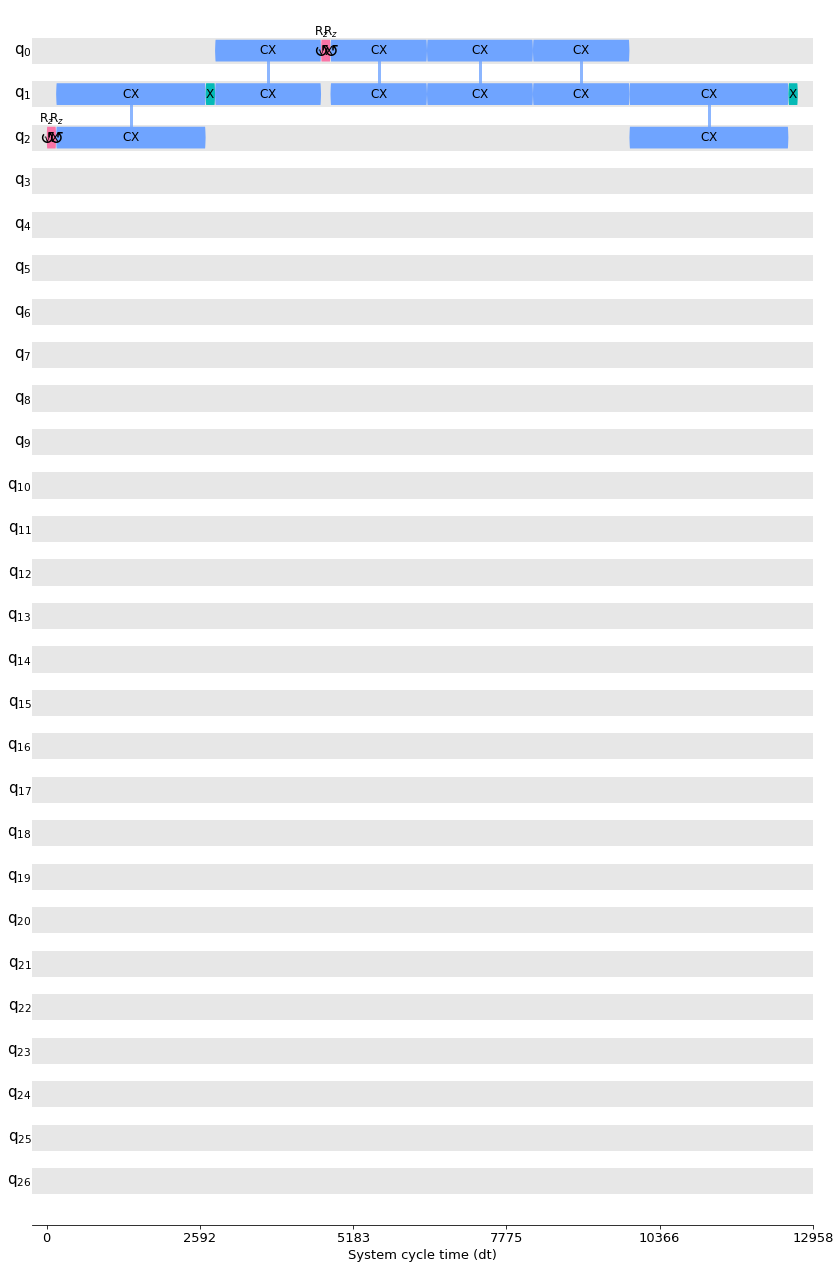

In [44]:
#Visualizing the scheduling of a circuit
from qiskit import QuantumCircuit, transpile, schedule
from qiskit.visualization.timeline import draw
from qiskit.test.mock import FakeParis #test on FakeVigo (5 qubit simulator)

qc = QuantumCircuit(3)
qc.h(0)
qc.cx(0,1)
qc.x(1)
qc.cx(1,2)
qc.h(2)
qc.cx(2, 0)
qc.x(2)

backend = FakeParis()
qc = transpile(qc, backend, scheduling_method='alap')
draw(qc)

In [41]:
qc.draw(fold=-1)

┌─────────────────┐                                          ┌───┐   ┌─────────┐    ┌────┐┌─────────┐     ┌───┐     ┌─────────────────┐                  
        q_2 -> 0 ┤ DELAY(2848[dt]) ├──────────────────────────────────────────┤ X ├───┤ RZ(π/2) ├────┤ √X ├┤ RZ(π/2) ├──■──┤ X ├──■──┤ DELAY(2848[dt]) ├──────────────────
                 └┬────────────────┤                  ┌───┐       ┌───┐       └─┬─┘┌──┴─────────┴───┐└────┘└─────────┘┌─┴─┐└─┬─┘┌─┴─┐└─────────────────┘      ┌───┐       
        q_1 -> 1 ─┤ DELAY(160[dt]) ├──────────────────┤ X ├───────┤ X ├─────────■──┤ DELAY(160[dt]) ├─────────────────┤ X ├──■──┤ X ├─────────■───────────────┤ X ├───────
                  └──┬─────────┬───┘ ┌────┐┌─────────┐└─┬─┘┌──────┴───┴──────┐     └────────────────┘                 └───┘     └───┘       ┌─┴─┐       ┌─────┴───┴──────┐
        q_0 -> 2 ────┤ RZ(π/2) ├─────┤ √X ├┤ RZ(π/2) ├──■──┤ DELAY(7168[dt]) ├──────────────────────────────────────────────────────────────┤ X ├───────┤ DELAY(160[dt]) ├
                 ┌───┴─────────┴────┐└────┘└─────────┘     └─────────────────┘                                                              └───┘       └────────────────┘
  ancilla_0 -> 3 ┤ DELAY(12704[dt]) ├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                 ├──────────────────┤                                                                                                                                     
  ancilla_1 -> 4 ┤ DELAY(12704[dt]) ├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                 ├──────────────────┤                                                                                                                                     
  ancilla_2 -> 5 ┤ DELAY(12704[dt]) ├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                 ├──────────────────┤                                                                                                                                     
  ancilla_3 -> 6 ┤ DELAY(12704[dt]) ├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                 ├──────────────────┤                                                                                                                                     
  ancilla_4 -> 7 ┤ DELAY(12704[dt]) ├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                 ├──────────────────┤                                                                                                                                     
  ancilla_5 -> 8 ┤ DELAY(12704[dt]) ├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                 ├──────────────────┤                                                                                                                                     
  ancilla_6 -> 9 ┤ DELAY(12704[dt]) ├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                 ├──────────────────┤                                                                                                                                     
 ancilla_7 -> 10 ┤ DELAY(12704[dt]) ├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                 ├──────────────────┤                                                                                                                                     
 ancilla_8 -> 11 ┤ DELAY(12704[dt]) ├───────────────────────────────────────────────

Now construct a pass manager and run the predefined pass CrossTalkDelayReplace on the qc2 circuit.

In [107]:
from qiskit.transpiler import PassManager

pm = PassManager()
pm.append([CrossTalkDelayReplace(backend.configuration().coupling_map)])

out_qc2 = pm.run(qc)
qc.draw(fold=-1)

Delay(duration=2848[unit=dt]) [Qubit(QuantumRegister(27, 'q'), 0)] 2848
Operating on qubit  Qubit(QuantumRegister(27, 'q'), 0)
  Found a delay :)
  Added  2848  to clock
Delay(duration=160[unit=dt]) [Qubit(QuantumRegister(27, 'q'), 1)] 160
Operating on qubit  Qubit(QuantumRegister(27, 'q'), 1)
  Found a delay :)
  Added  160  to clock
<qiskit.circuit.library.standard_gates.rz.RZGate object at 0x1465282e0> [Qubit(QuantumRegister(27, 'q'), 2)] 0
Operating on qubit  Qubit(QuantumRegister(27, 'q'), 2)
  Delay not found. I is ANGERY
    non-delay type is " <class 'qiskit.circuit.library.standard_gates.rz.RZGate'> "
  Added  0  to clock
<qiskit.circuit.library.standard_gates.sx.SXGate object at 0x146528910> [Qubit(QuantumRegister(27, 'q'), 2)] 160
Operating on qubit  Qubit(QuantumRegister(27, 'q'), 2)
  Delay not found. I is ANGERY
    non-delay type is " <class 'qiskit.circuit.library.standard_gates.sx.SXGate'> "
  Added  160  to clock
<qiskit.circuit.library.standard_gates.rz.RZGate object

KeyError: Qubit(QuantumRegister(27, 'q'), 1)

In [79]:
out_qc2.draw(fold=-1)

┌─────────────────┐                                          ┌───┐   ┌─────────┐    ┌────┐┌─────────┐     ┌───┐     ┌─────────────────┐                  
 q_0: ┤ DELAY(2848[dt]) ├──────────────────────────────────────────┤ X ├───┤ RZ(π/2) ├────┤ √X ├┤ RZ(π/2) ├──■──┤ X ├──■──┤ DELAY(2848[dt]) ├──────────────────
      └┬────────────────┤                  ┌───┐       ┌───┐       └─┬─┘┌──┴─────────┴───┐└────┘└─────────┘┌─┴─┐└─┬─┘┌─┴─┐└─────────────────┘      ┌───┐       
 q_1: ─┤ DELAY(160[dt]) ├──────────────────┤ X ├───────┤ X ├─────────■──┤ DELAY(160[dt]) ├─────────────────┤ X ├──■──┤ X ├─────────■───────────────┤ X ├───────
       └──┬─────────┬───┘ ┌────┐┌─────────┐└─┬─┘┌──────┴───┴──────┐     └────────────────┘                 └───┘     └───┘       ┌─┴─┐       ┌─────┴───┴──────┐
 q_2: ────┤ RZ(π/2) ├─────┤ √X ├┤ RZ(π/2) ├──■──┤ DELAY(7168[dt]) ├──────────────────────────────────────────────────────────────┤ X ├───────┤ DELAY(160[dt]) ├
      ┌───┴─────────┴────┐└────┘└─────────┘     └─────────────────┘                                                              └───┘       └────────────────┘
 q_3: ┤ DELAY(12704[dt]) ├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      ├──────────────────┤                                                                                                                                     
 q_4: ┤ DELAY(12704[dt]) ├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      ├──────────────────┤                                                                                                                                     
 q_5: ┤ DELAY(12704[dt]) ├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      ├──────────────────┤                                                                                                                                     
 q_6: ┤ DELAY(12704[dt]) ├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      ├──────────────────┤                                                                                                                                     
 q_7: ┤ DELAY(12704[dt]) ├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      ├──────────────────┤                                                                                                                                     
 q_8: ┤ DELAY(12704[dt]) ├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      ├──────────────────┤                                                                                                                                     
 q_9: ┤ DELAY(12704[dt]) ├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      ├──────────────────┤                                                                                                                                     
q_10: ┤ DELAY(12704[dt]) ├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      ├──────────────────┤                                                                                                                                     
q_11: ┤ DELAY(12704[dt]) ├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      ├──────────────────┤                                                                                                                                     
q_12: 